# **WEB SEARCH ENGINE**
prepared in DSAI 301 - INTRODUCTION TO PYTHON PROGRAMMING - BOGAZICI UNIVERSITY
special thanks to teachings of Asst. Prof. Dr. Huseyin Oktay ALTUN

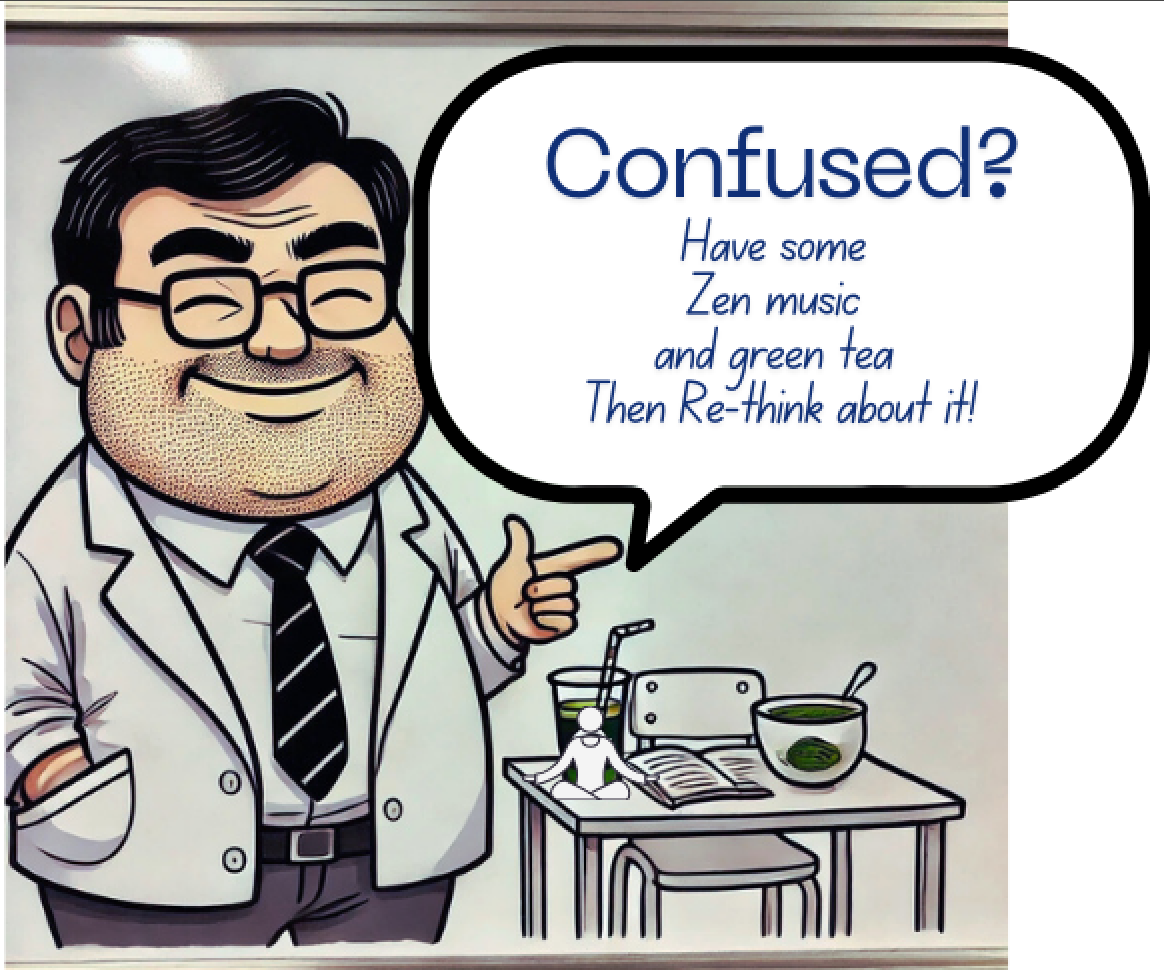

Lecture 1: “**Programming isn’t about what you know; it’s about what you can figure out**.”
– *Chris Pine*

Lecture 2 - 8: “**Confusion is part of programming**.”
– *Felienne Hermans*

Lecture 3: “**An expert is a person who has made all the mistakes that can be made in a very narrow field**.”
– *Neils Bohr*

Lecture 4: “**Code is like humor. When you have to explain it, it’s bad.**”
– *Cory House*

Lecture 5: “**Coding like poetry should be short and concise.**”
– *Santosh Kalwar*

Lecture 6: “**That’s the thing about people who think they hate computers. What they really hate is lousy programmers**.”
– *Larry Niven*

Lecture 7: “**Testing leads to failure, and failure leads to understanding.**”
– *Burt Rutan*

Lecture 9 - 10: “ **The most disastrous thing that you can ever learn is
your first programming language**.”
– *Joshua Bloch*

Lecture 11: “ **Everybody should learn to program a computer, because
it teaches you how to think**.”
– *Steve Jobs*

Lecture 12: “ **In programming, the hard part isn’t solving problems,
but deciding what problems to solve.**”
– *Paul Graham*

Lecture 13: “**Programming is about managing complexity.**”
– *Bruce Eckel*

Lecture 14: “**Before you marry a person, you should first make them use a computer with slow Internet to see who they really are.**”
– *Will Ferrell*

Lecture 15: “**Testing can only prove the presence of bugs, not their absence**.”
– *Edsger W. Dijkstra*

Lecture 16: “**The most dangerous phrase in the language is, ‘We’ve always done it this way.’**”
– *Grace Hopper*

Lecture 17: “**Every great developer you know got there by solving problems they were unqualified to solve until they actually did it.**”
– *Patrick McKenzie*

Lecture 19: “**The Internet is becoming the town square for the global village of tomorrow.**”
– *Bill Gates*

Lecture 20: “**First, solve the problem. Then, write the code.**”
– *John Johnson*

In [1]:
"""
Part 1> Finding Data

The flow of execution is:

Takes a seed URL crawlWeb(seed)
Get the page content using getPage
Find all links on that page using get_all_links (which uses get_next_target)
Visits each linked page recursively and Adds new links to our to-crawl list using union

"""

def getPage(url): # This function does the actual work of fetching web pages:
  try:
    import urllib.request
    page = urllib.request.urlopen(url).read()
    page = page.decode("utf-8")
    return page
  except:
    return ""



def get_next_target(page):   # This is our link finder. It looks through HTML in the given page to find the next page/link:
  start_link = page.find('<a href=')
  if start_link == -1:
    return None, 0
  start_quote = page.find('"', start_link)
  end_quote = page.find('"', start_quote+1)
  url = page[start_quote + 1:end_quote]
  return url, end_quote




def get_all_links(page):  # This function uses get_next_target repeatedly to find all links on a page and adds them into a list called links:
  links = []
  while True:
    url, endpos = get_next_target(page)
    if url:
      links.append(url)
      page = page[endpos:]
    else:
      break
  return links


# Helper function union which helps us add new URLs to our to-crawl list without duplicates
# it will be used in Crawlweb function later

def union(list1,list2):
  for scoop in list2:
    if scoop not in list1:
      list1.append(scoop)
  return list1

In [2]:
"""
Part 2> Building Index

The flow of execution is:

Cleans HTML content (get_clean_page)
Builds a searchable index (add_to_index, add_page_to_index)
"""

def getclearpage(content): # The HTML cleaning function:
    # Extract title
    title = content[content.find("<title>")+7:content.find("</title>")]
    # Extract body
    body = content[content.find("<body>")+6:content.find("</body>")]

    # Remove HTML tags from body
    while body.find(">") != -1:  # While there are still HTML tags
        start = body.find("<")   # Find start of tag
        end = body.find(">")     # Find end of tag
        # Remove the tag by taking everything before "<" and after ">"
        body = body[:start] + body[end+1:]

    # Return combined clean text
    return title + body

def add_to_index(index, keyword, url):
  if keyword in index:
    index[keyword].append(url)
  else:
    index[keyword] = [url]

def addPageToIndex(index, url, content):
  content = getclearpage(content)
  words = content.split()
  for word in words:
    add_to_index(index, word, url)


In [3]:
"""
Part 3> Ranking

The flow of execution is:

Generates a graph indicating the interconnections between web pages while crawling the web (crawlWeb)
Defines the ranking (computeRanks)
Provides search functionality (lookup)
"""

def crawlWeb(seed):
    tocrawl = [seed]
    crawled = []
    index = {}
    graph = {}

    while tocrawl:
        page = tocrawl.pop()
        if page not in crawled:
            content = getPage(page)
            outlinks = get_all_links(content)
            graph[page] = outlinks
            addPageToIndex(index, page, content)
            union(tocrawl, outlinks)
            crawled.append(page)

    return index, graph  # Return both index and graph

def computeRanks(graph): # This function takes a graph dictionary as input where keys are pages and values are lists of outlinks:

    d = 0.8
    N = len(graph)
    numloops = 10
    ranks = {}

    for page in graph:
        ranks[page] = 1/N

    for i in range(0, numloops):
        newranks = {}

        for page in graph:
            newrank = (1-d)/N

            for node in graph:
                if page in graph[node]:


                    newrank = newrank + d*(ranks[node]/len(graph[node]))  # (node's rank * dampening factor) / (number of outbound links from node)

            newranks[page] = newrank      # Store the calculated new rank for this page

        ranks = newranks                  # Update the ranks dictionary with new values

    return newranks                       # Return the final computed ranks


def lookup(index, key, graph=None, computing_procedure=None):
    # Initialize an output string to collect results
    output = ""

    # Check if the key exists in the index
    if key not in index:
        output += f"No results found for key: {key}\n"
    else:
        # Get unique URLs
        seen = []
        unique_urls = []
        for url in index[key]:
            if url not in seen:
                seen.append(url)
                unique_urls.append(url)

        # Standard lookup
        if graph is None:
            for url in unique_urls:
                output += url + "\n"

        # Lookup with ranking
        elif computing_procedure:
            ranks = computing_procedure(graph)
            sorted_urls = sorted(unique_urls, key=lambda x: ranks.get(x, 0), reverse=True)  # ALLOWED BUILT-IN FUNCTION
            for url in sorted_urls:
                output += url + "\n"

        # Lookup with warning
        else:
            output += "Warning: No ranking procedure given\n"
            for url in unique_urls:
                output += url + "\n"

    # Print all collected outputs at once
    print(output)  # Single print statement


In [4]:
# Execution
seed_url = "https://searchengineplaces.com.tr/"
index, graph = crawlWeb(seed_url)
ranks = computeRanks(graph)


lookup(index, "in")
lookup(index, "in", graph)
lookup(index, "in", graph, computeRanks)

http://www.searchengineplaces.com.tr/travel_guide.html
http://www.searchengineplaces.com.tr/istanbul.html
http://www.searchengineplaces.com.tr/galata_tower.html
http://www.searchengineplaces.com.tr/maidens_tower.html
http://www.searchengineplaces.com.tr/konya.html
http://www.searchengineplaces.com.tr/mevlana.html

http://www.searchengineplaces.com.tr/travel_guide.html
http://www.searchengineplaces.com.tr/istanbul.html
http://www.searchengineplaces.com.tr/galata_tower.html
http://www.searchengineplaces.com.tr/maidens_tower.html
http://www.searchengineplaces.com.tr/konya.html
http://www.searchengineplaces.com.tr/mevlana.html

http://www.searchengineplaces.com.tr/istanbul.html
http://www.searchengineplaces.com.tr/travel_guide.html
http://www.searchengineplaces.com.tr/galata_tower.html
http://www.searchengineplaces.com.tr/maidens_tower.html
http://www.searchengineplaces.com.tr/konya.html
http://www.searchengineplaces.com.tr/mevlana.html

